In [1]:
from quagmire import SurfaceProcessMesh
from quagmire import tools as meshtools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import petsc4py


In [2]:
import h5py

meshFile = h5py.File(name="../Scripts/Octopants.h5", mode="r")
points = meshFile["geometry"]["vertices"]
x1 = points.value[:,0]
y1 = points.value[:,1]
bmask = meshFile["fields"]["bmask"].value[:].astype(bool)
height = meshFile["fields"]["height"].value[:]
lakes = meshFile["fields"]["swamps"].value[:]

In [3]:
dm  = meshtools.create_DMPlex_from_points(x1,y1,bmask=bmask)
SPM = SurfaceProcessMesh(dm)
x = SPM.coords[:,0]
y = SPM.coords[:,1]


0 - Delaunay triangulation 0.175032s
0 - Calculate node weights and area 0.0047s
0 - Find boundaries 0.001733s
0 - cKDTree 0.014917s
0 - Construct neighbour cloud array 0.396193s
0 - Construct rbf weights 0.093099s


In [4]:
from scipy.spatial import ckdtree
old_nodes = ckdtree.cKDTree( points.value )

In [5]:
distance, mapping = old_nodes.query(SPM.coords)
SPM.update_height(height[mapping])
lakefill = lakes[mapping]

0 - Compute slopes 0.156173s
0 - Build downhill matrices 0.35663s


In [6]:
its, flowpaths2 = SPM.cumulative_flow_verbose(SPM.area, maximum_its=2000, verbose=True)

0: Max Delta - 0.00617541736029 
10: Max Delta - 0.00654149209367 
20: Max Delta - 0.00413616975795 
30: Max Delta - 0.0038976714588 
40: Max Delta - 0.00267203479796 
50: Max Delta - 0.00332112902026 
60: Max Delta - 0.0040593173007 
70: Max Delta - 0.00375958527521 
80: Max Delta - 0.00263992653643 
90: Max Delta - 0.00410991544071 
100: Max Delta - 0.00385712594581 
110: Max Delta - 0.00399877779692 
120: Max Delta - 0.00256274927895 
130: Max Delta - 0.00333788540007 
140: Max Delta - 0.00381873948888 
150: Max Delta - 0.00259898774156 
160: Max Delta - 0.00529787794267 
170: Max Delta - 0.0022310514207 
180: Max Delta - 0.00111131445054 
190: Max Delta - 0.00116626972777 
200: Max Delta - 0.00174722666305 
210: Max Delta - 0.00203968518337 
220: Max Delta - 0.00146048147397 
230: Max Delta - 0.000979223134463 
240: Max Delta - 0.00117846080096 
250: Max Delta - 0.0031235903905 
260: Max Delta - 0.00265494803805 
270: Max Delta - 0.00163025870626 
280: Max Delta - 0.00137652968015 

In [7]:
low_points = SPM.identify_low_points()
print low_points

[ 1649  3134  6940 83819]


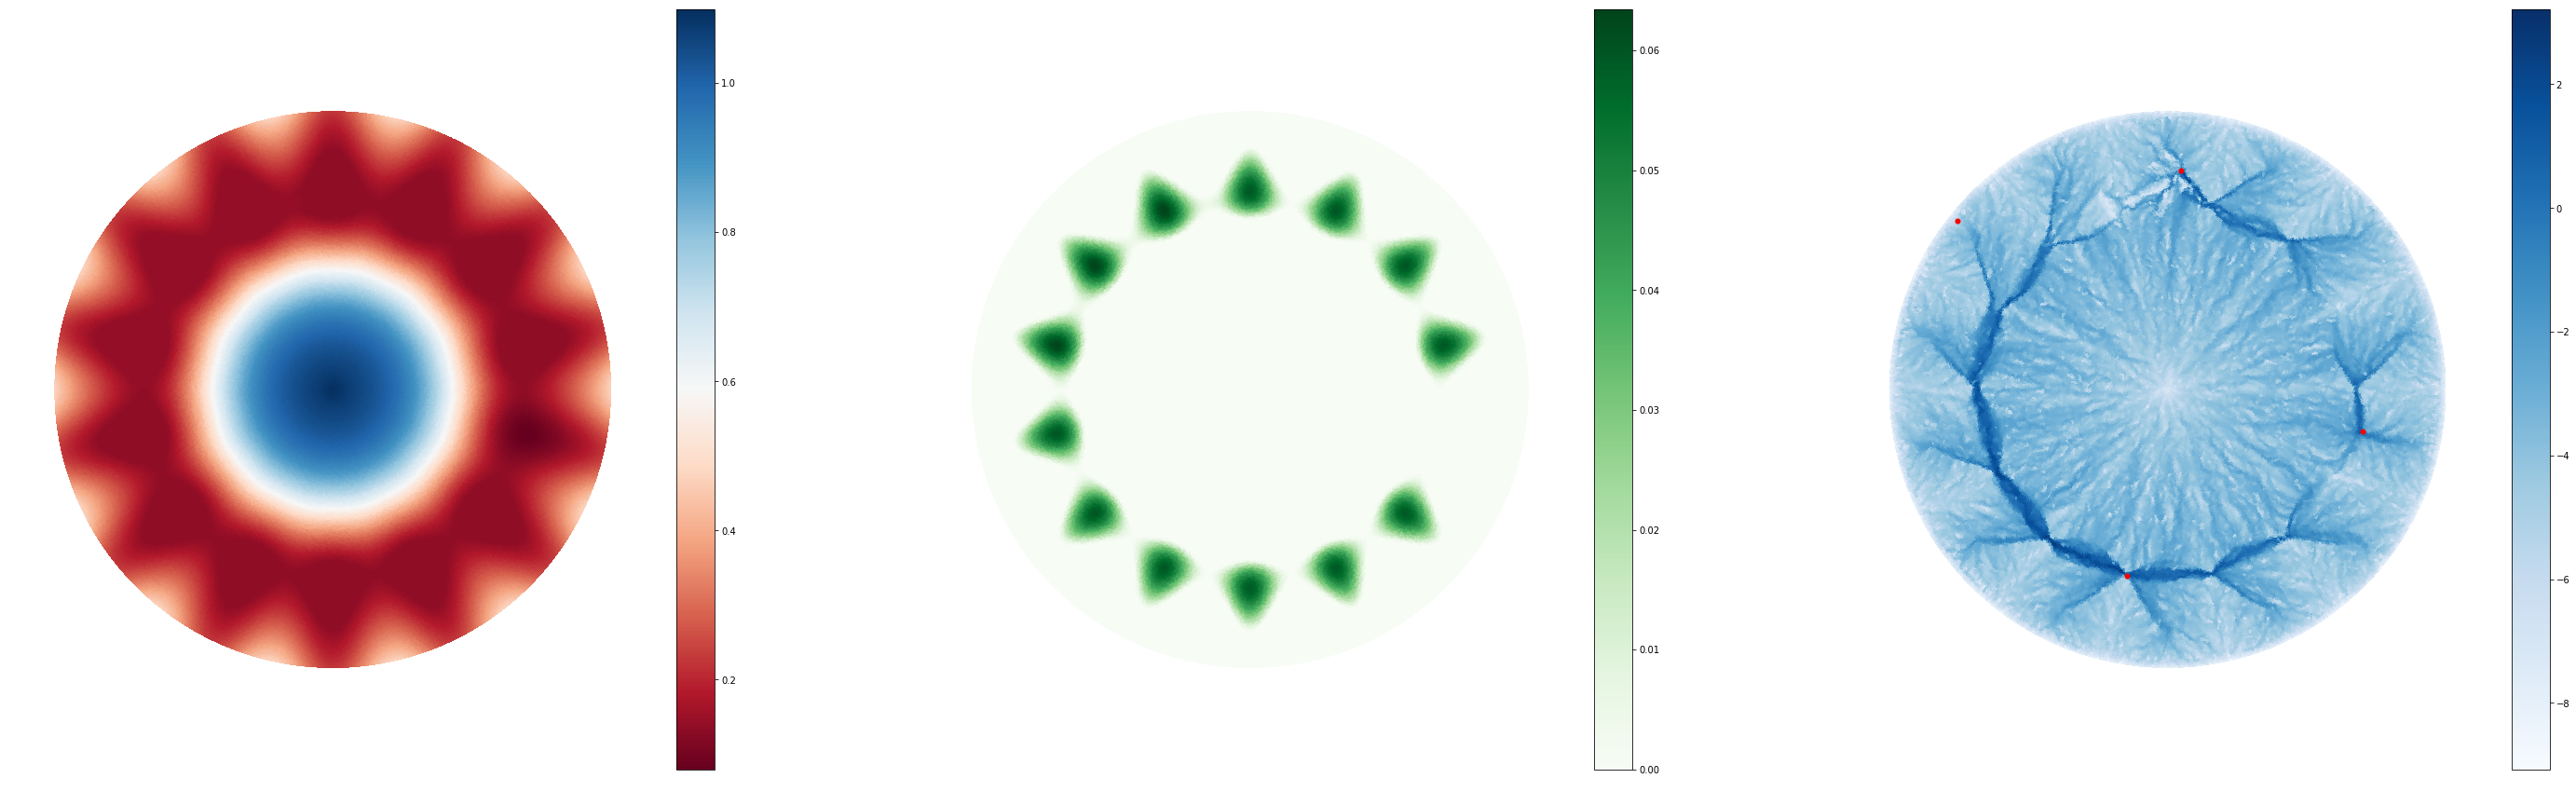

In [8]:
# Plot the stream power, erosion and deposition rates
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(50,15))
for ax in [ax1, ax2, ax3]:
    ax.axis('equal')
    ax.axis('off')

    
im1 = ax1.tripcolor(x, y, SPM.tri.simplices, SPM.height, cmap=plt.cm.RdBu)    
# ax1.tripcolor(x, y, SPM.tri.simplices, height, 10)

# im1 = ax1.tripcolor(x, y, sp.tri.simplices, sp.height, cmap=plt.cm.terrain)
im2 = ax2.tripcolor(x, y, SPM.tri.simplices, lakefill, cmap='Greens', vmax=None)

# ax3.tripcolor(x, y, SPM.tri.simplices, height, cmap=plt.cm.gray, zorder=1, vmin=-0.75, alpha=0.5)
im3 = ax3.tripcolor(x, y, SPM.tri.simplices, np.log(flowpaths2), cmap='Blues', zorder=0)
ax3.scatter(x[low_points], y[low_points], color="Red", s=25.0)

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)
plt.show()



In [9]:
from petsc4py import PETSc

PETSc.Scatter.toAll()